# Inference

In [1]:
import torch
import torchvision
print(torch.__version__) 
print(torchvision.__version__)

2.0.1
0.15.2


In [2]:
import os
os.environ['TORCH_HOME'] = '/data/cmpe249-fa23/argo1COCO'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

### Step 1: Initialize model with the best available weights

In [3]:
import datetime
import os
import time
import math
import sys
import torch
import torch.utils.data
import torchvision
import torchvision.models.detection

from DeepDataMiningLearning.detection import utils
from DeepDataMiningLearning.detection.trainutils import create_aspect_ratio_groups, GroupedBatchSampler

from DeepDataMiningLearning.detection.dataset import get_dataset #get_cocodataset, get_kittidataset, get_transform
from DeepDataMiningLearning.detection.models import get_torchvision_detection_models, modify_fasterrcnnheader #get_torchvision_detection_models, modify_fasterrcnnheader
from DeepDataMiningLearning.detection.myevaluator import simplemodelevaluate, modelevaluate

# Load fine tunned Fast-RCNN model
model_name = 'fasterrcnn_resnet50_fpn_v2'
num_classes = 8
trainable = 0
model_path = '/data/cmpe249-fa23/argo1COCO/trainoutput/model_3.pth'


model, preprocess, weights, classes = get_torchvision_detection_models(model_name)
model = modify_fasterrcnnheader(model, num_classes, freeze=False)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model'])

/home/015957045/anaconda3/envs/mycondapy310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>

In [6]:
## Load custom_RCNN model

from DeepDataMiningLearning.detection.models import CustomRCNN

name = 'cusrcnn'
checkpoint = torch.load('/data/cmpe249-fa23/argo1COCO/trainoutput/cusrcnn_model_1.pth')
model = CustomRCNN(backbone_modulename="resnet152",
            trainable_layers=trainable,
            num_classes=num_classes,
            out_channels=256,min_size=800,max_size=1333)
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device).eval()

## Step 2: Open a sample from the test set

Random image path: /data/cmpe249-fa23/Argoverse/Argoverse-1.1/images/test/0f0d7759-fa6e-3296-b528-6c862d061bdd/ring_front_center/ring_front_center_315974301693082480.jpg
Image height: 1200
Image width: 1920


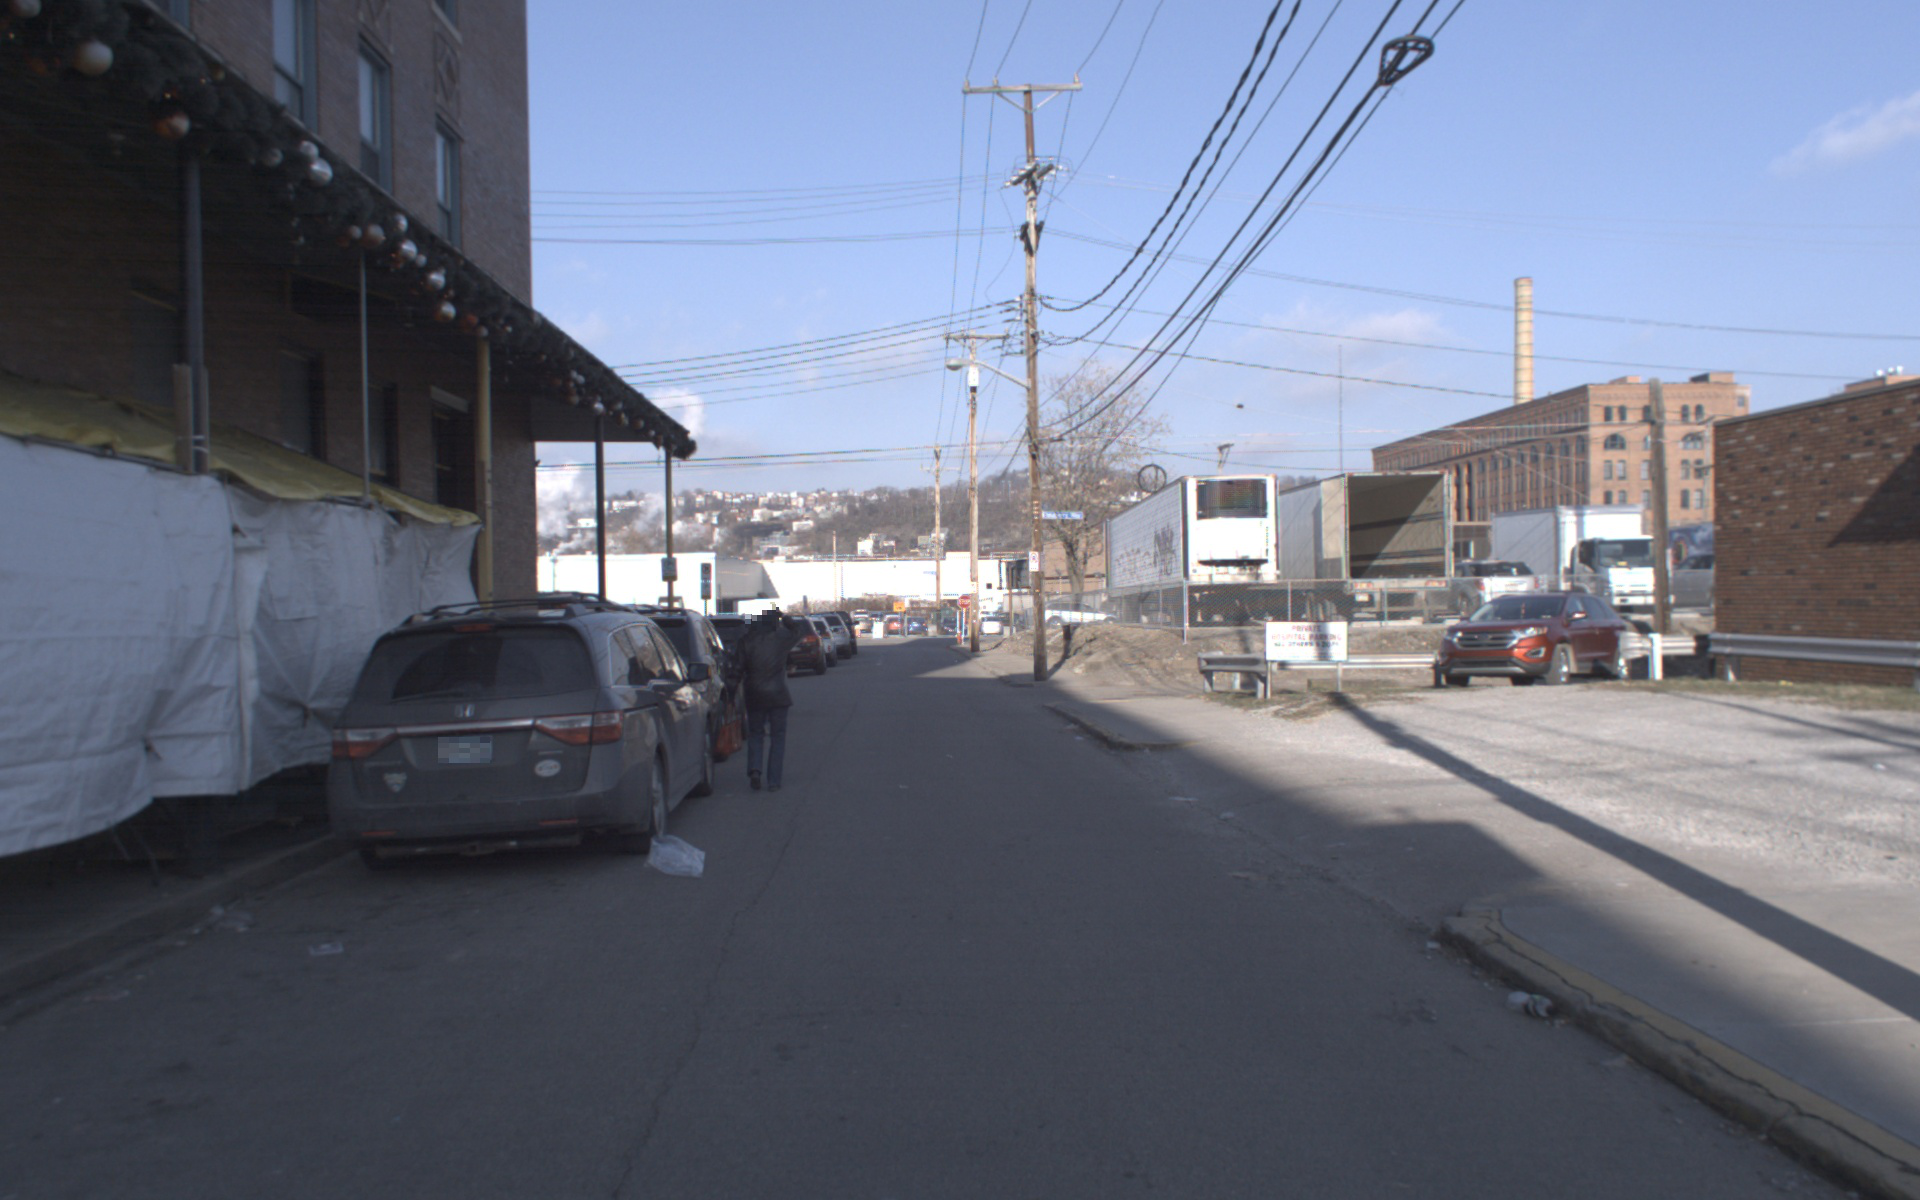

In [8]:
from PIL import Image
import random
from pathlib import Path

random.seed(111)
image_path_list_test = list(Path('/data/cmpe249-fa23/Argoverse/Argoverse-1.1/images/test').glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list_test)
img = Image.open(random_image_path)
print(f"Random image path: {random_image_path}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
display(img)

## Step 3: Transform the test image and perform inference

In [9]:
# reference: https://github.com/sovit-123/fasterrcnn-pytorch-training-pipeline/blob/main/inference.py
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms as transforms

img_array = np.array(img)
orig_image = cv2.imread(str(random_image_path))
frame_height, frame_width, _ = orig_image.shape
RESIZE_TO = frame_width

def resize(im, img_size=640, square=False):
    # Aspect ratio resize
    if square:
        im = cv2.resize(im, (img_size, img_size))
    else:
        h0, w0 = im.shape[:2]  # orig hw
        r = img_size / max(h0, w0)  # ratio
        if r != 1:  # if sizes are not equal
            im = cv2.resize(im, (int(w0 * r), int(h0 * r)))
    return im
def infer_transforms(image):
    # Define the torchvision image transforms.
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
    ])
    return transform(image)
image_resized = resize(orig_image, RESIZE_TO, square=False)
image = image_resized.copy()

# BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = image.copy()
image = infer_transforms(image)
# Add batch dimension.
image = torch.unsqueeze(image, 0)
with torch.no_grad():
    outputs = model(image.to(device))

In [10]:
outputs

[{'boxes': tensor([[1432.7339,  589.6716, 1633.2850,  685.4189],
          [ 333.6612,  605.0877,  726.2083,  872.2939],
          [ 785.9803,  616.1690,  827.0280,  675.3116],
          [1104.3505,  470.2424, 1296.1318,  614.1671],
          [ 883.4398,  614.1161,  904.5442,  635.1700],
          [ 904.8444,  613.1262,  928.6536,  635.5083],
          [ 813.8741,  614.3560,  855.2862,  662.6669],
          [1244.0386,  475.1749, 1456.7288,  626.3984],
          [ 852.6316,  615.0103,  872.3179,  627.0421],
          [ 940.5712,  621.7981,  959.0087,  637.4394],
          [1443.1874,  558.6316, 1540.6846,  608.5267],
          [ 620.8459,  604.6335,  760.3076,  767.3129],
          [ 660.2521,  557.1675,  677.5519,  581.3522],
          [1560.4801,  532.5988, 1668.9968,  610.9453],
          [1503.0684,  514.1540, 1658.4429,  593.9163],
          [ 857.0471,  614.6780,  876.1740,  632.9036],
          [ 717.2830,  608.5414,  806.8867,  693.5582],
          [ 801.2339,  615.9612,  838.4

## Step 4: Draw predicted bounding boxes on the image

In [11]:
from matplotlib.patches import Rectangle
def compute_color_for_labels(label):
    """
    Simple function that adds fixed color depending on the class
    """
    palette = (2 ** 11 - 1, 2 ** 15 - 1, 2 ** 20 - 1)
    #color = [int((p * (label ** 2 - label + 1)) % 255) for p in palette]
    color = [int((p * ((label+5*label) ** 2 - label + 1)) % 255) for p in palette]
    return tuple(color)

def show_image_bbxyxy(image, pred_bbox, pred_ids, class_dic, prob, detection_threshold, title, savefigname=None):
    """Show a camera image and the given camera labels.
        Do not draw bboxes that have lower than detection threshold 
    """
        
    fig, ax = plt.subplots(1, 1, figsize=(20, 15))
    boxnum=len(pred_bbox)
    pred_bbox = [[(i[0], i[1]), (i[2], i[3])] for i in pred_bbox]
    #print(boxnum)
    if len(pred_ids)<1:
        print("No object detected")
        return image
    else:
        
        #print(pred_labels)
        for i in range(boxnum):#patch in pred_bbox:
            if prob[i] > detection_threshold:
                patch=pred_bbox[i]
                #print(patch)
                colorlabel=compute_color_for_labels(pred_ids[i]) #INSTANCE_Color[label]
                #print(colorlabel)#RGB value 0-255
                colorlabelnormalized = [float(i)/255 for i in colorlabel] #0-1
                label=class_dic[pred_ids[i]]
                #print(label)
                ax.add_patch(Rectangle(
                xy=patch[0],#(patch[0], patch[1]), #xmin ymin
                width=patch[1][0]-patch[0][0],#patch[2] - patch[0],
                height=patch[1][1]-patch[0][1],#patch[3] - patch[1],
                linewidth=4,
                edgecolor=colorlabelnormalized,#"red",
                facecolor='none'))
                ax.text(patch[0][0]-5, patch[0][1]-5, label, color=colorlabelnormalized, fontsize=15)
            else:
                continue
        
    ax.imshow(image)
    
    ax.title.set_text(title)
    ax.grid(False)
    ax.axis('off')
    
    if savefigname is not None:
        fig.savefig(savefigname)

In [17]:
CLASS = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'bus', 5: 'truck', 6: 'traffic_light', 7: 'stop_sign'}
boxes_xyxy = outputs[0]['boxes'].cpu().detach().numpy()
ids = outputs[0]['labels'].cpu().detach().numpy()
scores = outputs[0]['scores'].cpu().detach().numpy()
detec_thresh = 0.9
ex = 'inference example'

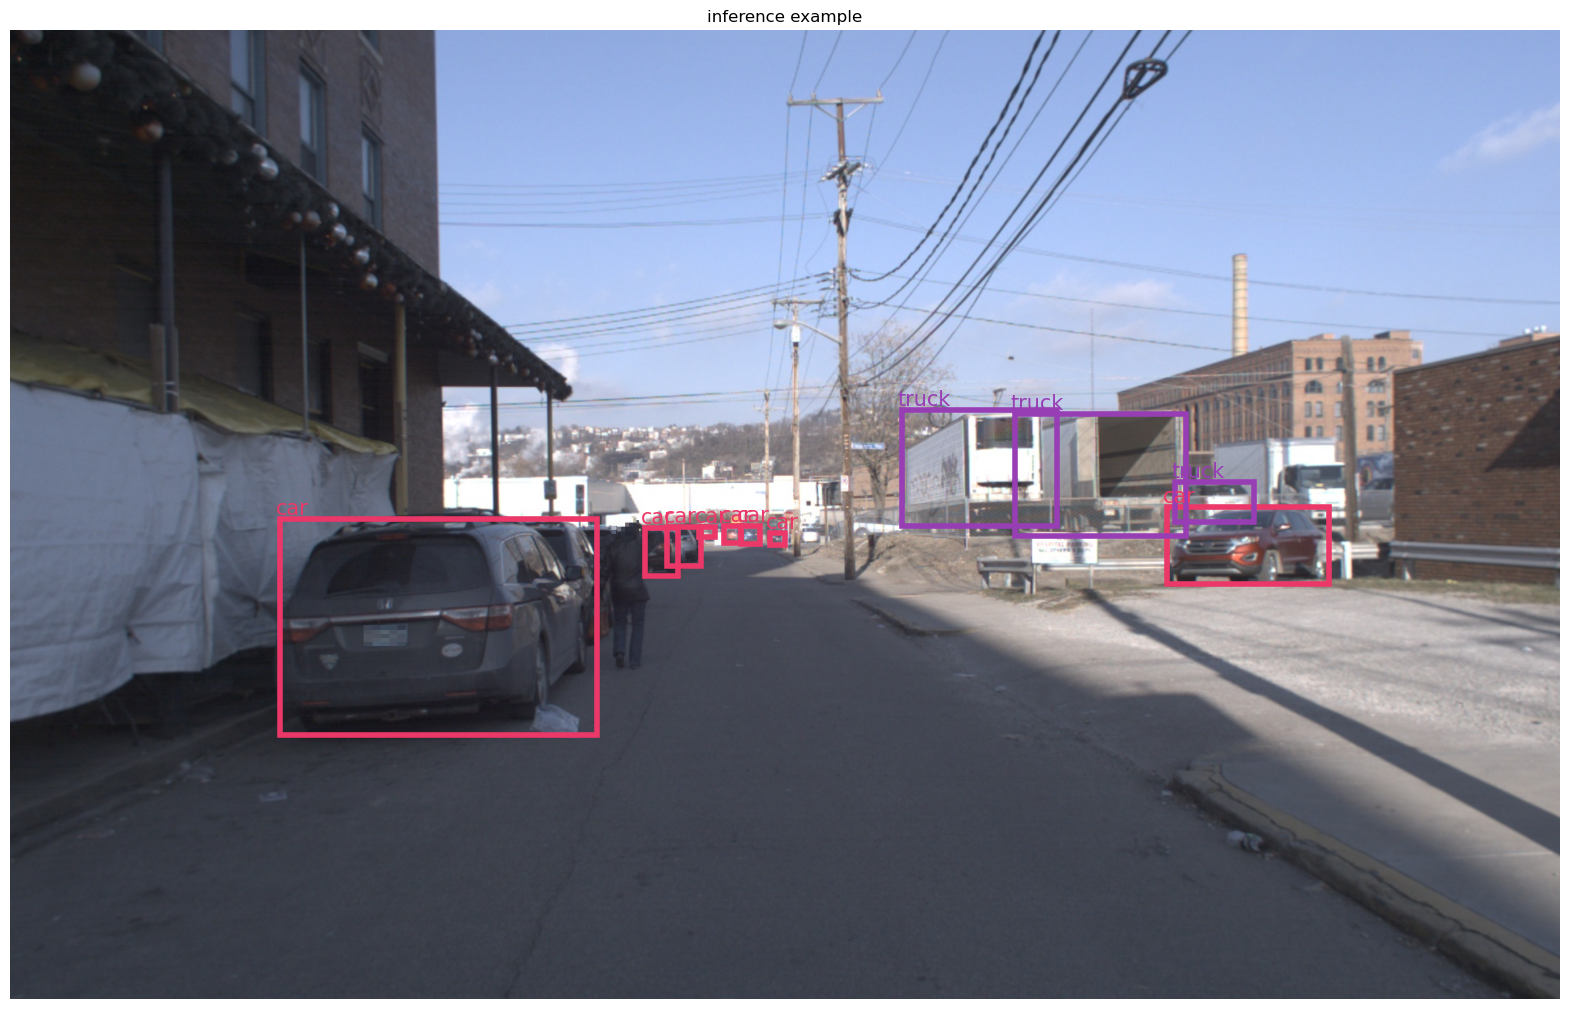

In [18]:
show_image_bbxyxy(img, boxes_xyxy, ids, CLASS, scores, detec_thresh, ex, 
                  savefigname = '/home/015957045/cmpe249/prediction/inference_test_cusrcnn_2.jpg')





## Use a batch of testdata and measure inference time

i: 77
[{'boxes': tensor([[ 920.8407,  595.8719, 1047.1697,  707.8773],
        [ 949.6595,  456.5225,  959.2902,  482.8184],
        [ 220.4448,  621.2354,  330.6532,  676.6718],
        [ 760.6194,  612.2863,  824.2529,  657.4924],
        [1415.6963,  575.2031, 1781.7273,  710.2076],
        [1777.8783,  581.2218, 1917.5790,  702.0662],
        [ 701.1367,  535.9243,  711.3515,  561.0419],
        [ 885.9246,  602.1725,  906.6810,  627.2147],
        [ 792.3191,  605.8447,  840.2616,  648.5829],
        [ 840.9528,  609.1134,  864.0519,  639.6393],
        [1023.1302,  590.1974, 1089.1644,  649.3896],
        [ 925.8344,  596.1595,  963.0092,  633.7535]], device='cuda:0'), 'labels': tensor([2, 6, 2, 2, 2, 2, 6, 2, 2, 2, 5, 2], device='cuda:0'), 'scores': tensor([0.9967, 0.9953, 0.9908, 0.9902, 0.9854, 0.9827, 0.9720, 0.9338, 0.9260,
        0.9162, 0.9053, 0.9008], device='cuda:0')}]
TEST PREDICTIONS COMPLETE
Average FPS: 7.790


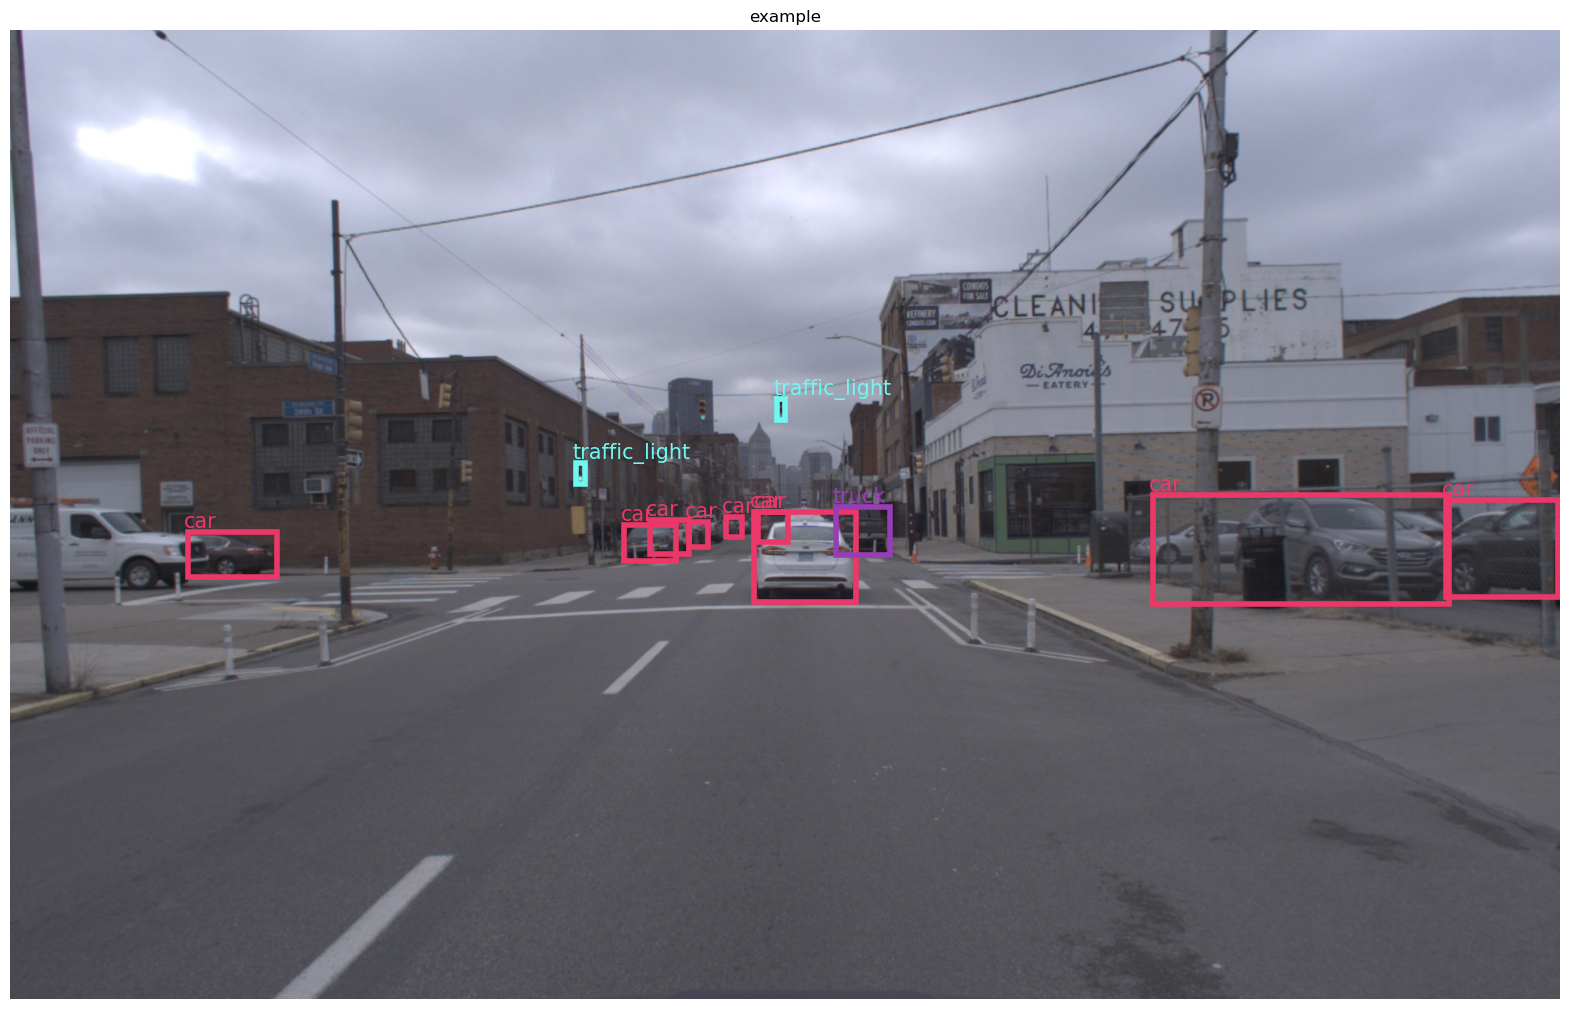

In [18]:
import time
frame_count = 0
total_fps = 0

# only test 1000 images to save time
image_path_list_test = image_path_list_test[:1000]

for i in range(len(image_path_list_test)):
    temp = image_path_list_test[i]
    orig_image = cv2.imread(str(temp))
    frame_height, frame_width, _ = orig_image.shape
    RESIZE_TO = frame_width
    image_resized = resize(orig_image, RESIZE_TO, square=False)
    image = image_resized.copy()

    # BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = image.copy()
    image = infer_transforms(image)

    start_time = time.time()
    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        outputs = model(image.to(device))
    end_time = time.time()

    # update total_fps
    total_fps += 1/(end_time - start_time)

    # increse frame count
    frame_count += 1
    if i == 77:
        print(f"i: {i}")
        print(outputs)
        boxes_xyxy = outputs[0]['boxes'].cpu().detach().numpy()
        ids = outputs[0]['labels'].cpu().detach().numpy()
        show_image_bbxyxy(img, boxes_xyxy, ids, CLASS, 'example')
print('TEST PREDICTIONS COMPLETE')
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")

## Inference for video  
### reference: https://github.com/sovit-123/fasterrcnn-pytorch-training-pipeline/blob/main/inference_video.py

In [37]:
def convert_detections(outputs, detection_threshold, class_dic):
    """
    Return the bounding boxes, scores, and classes.
    """
    boxes = outputs[0]['boxes'].data.numpy()
    labels = outputs[0]['labels'].data.numpy()
    scores = outputs[0]['scores'].data.numpy()

    # Filter out boxes according to `detection_threshold`.
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    draw_boxes = boxes.copy()
    # Get all the predicited class names.
    pred_classes = [class_dic[i] for i in outputs[0]['labels'].cpu().numpy()]

    return draw_boxes, pred_classes, scores, labels

def inference_annotations(draw_boxes, pred_classes, scores, labels, classes, colors, orig_image, image):
    height, width, _ = orig_image.shape
    lw = max(round(sum(orig_image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    
    # Draw the bounding boxes and write the class name on top of it.
    for j, box in enumerate(draw_boxes):
        p1 = (int(box[0]/image.shape[1]*width), int(box[1]/image.shape[0]*height))
        p2 = (int(box[2]/image.shape[1]*width), int(box[3]/image.shape[0]*height))
        class_name = pred_classes[j]

        color = colors[labels[j]]
        cv2.rectangle(
            orig_image,
            p1, p2,
            color=color, 
            thickness=lw,
            lineType=cv2.LINE_AA
        )
        
        final_label = class_name + ' ' + str(round(scores[j], 2))
        w, h = cv2.getTextSize(
            final_label, 
            cv2.FONT_HERSHEY_SIMPLEX, 
            fontScale=lw / 3, 
            thickness=tf
        )[0]  # text width, height
        w = int(w - (0.20 * w))
        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
        cv2.rectangle(
            orig_image, 
            p1, 
            p2, 
            color=color, 
            thickness=-1, 
            lineType=cv2.LINE_AA
        )  
        cv2.putText(
            orig_image, 
            final_label, 
            (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
            cv2.FONT_HERSHEY_SIMPLEX, 
            fontScale=lw / 3.8, 
            color=(255, 255, 255), 
            thickness=tf, 
            lineType=cv2.LINE_AA
        )
    return orig_image



In [44]:
# reference: https://github.com/sovit-123/fasterrcnn-pytorch-training-pipeline/blob/main/inference_video.py

video_path = '/home/015957045/cmpe249/video_1.mp4'
COLORS = np.random.uniform(0, 255, size=(num_classes, 3))

cap = cv2.VideoCapture(video_path)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
origin_fps = float(cap.get(cv2.CAP_PROP_FPS))

OUT_DIR = '/home/015957045/cmpe249'
save_name = 'test_fRCNN'
out = cv2.VideoWriter(f"{OUT_DIR}/{save_name}.mp4", 
                        cv2.VideoWriter_fourcc(*'mp4v'), origin_fps, 
                        (frame_width, frame_height))

RESIZE_TO = frame_width
detection_threshold = 0.9
frame_count = 0
total_fps = 0
# read until end of video
while(cap.isOpened()):
    # capture each frame of the video
    ret, frame = cap.read()
    if ret:
        orig_frame = frame.copy()
        frame = resize(frame, RESIZE_TO, square=False)
        image = frame.copy()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = infer_transforms(image)
        # Add batch dimension.
        image = torch.unsqueeze(image, 0)
        # Get the start time.
        start_time = time.time()
        with torch.no_grad():
            # Get predictions for the current frame.
            outputs = model(image.to(device))
        inf_end_time = time.time()

        # Update total_fps
        forward_pass_time = inf_end_time - start_time
        fps = 1 / forward_pass_time
        total_fps += fps
        # Increment frame count.
        frame_count += 1

        # Load all detection to CPU for further operations.
        outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
        # Carry further only if there are detected boxes.
        if len(outputs[0]['boxes']) != 0:
            draw_boxes, pred_classes, scores, labels = convert_detections(outputs, detection_threshold, CLASS)
            frame = inference_annotations(
                draw_boxes, 
                pred_classes, 
                scores,
                labels,
                CLASS, 
                COLORS, 
                orig_frame, 
                frame)
        else:
            frame = orig_frame
                       
        out.write(frame.astype('uint8'))

    else:
        break

# Release VideoCapture().
cap.release()
# Close all frames and video windows.
cv2.destroyAllWindows()

# Calculate and print the average FPS.
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")


Average FPS: 7.956
